<a href="https://colab.research.google.com/github/hjarai/cs451-practicals/blob/main/p13_lr_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import many things!
import numpy as np
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from typing import List, Tuple, Dict
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import torch
from torch import nn, optim

# start off by seeding random number generators:
RANDOM_SEED = 12345
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# download our dataset ('shared.py')
import urllib

url = 'http://ciir.cs.umass.edu/downloads/poetry/id_datasets.jsonl'
path = 'poetry_id.jsonl'
# try connecting before creating output file...
with urllib.request.urlopen(url) as f:
    # create output file and download the rest.
    with open(path, "wb") as out:
        out.write(f.read())

In [ ]:
# load in the dataset, split it 'dataset_poetry.py'
df: pd.DataFrame = pd.read_json(path, lines=True)

features = pd.json_normalize(df.features)
features = features.join([df.poetry, df.words])

tv_f, test_f = train_test_split(features, test_size=0.25, random_state=RANDOM_SEED)
train_f, vali_f = train_test_split(tv_f, test_size=0.25, random_state=RANDOM_SEED)

textual = TfidfVectorizer(max_df=0.75, min_df=2, dtype=np.float32)
numeric = make_pipeline(DictVectorizer(sparse=False), StandardScaler())

def split(
    df: pd.DataFrame, fit: bool = False
) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    global numeric, textual
    y = np.array(df.pop("poetry").values)
    text = df.pop("words")
    if fit:
        textual.fit(text)
        numeric.fit(df.to_dict("records"))
    x_text = textual.transform(text)
    x_num = numeric.transform(df.to_dict("records"))
    x_merged = np.asarray(np.hstack([x_num, x_text.todense()]))
    return (y, {"textual": x_text, "numeric": x_num, "merged": x_merged})


y_train, Xd_train = split(train_f, fit=True)
y_vali, Xd_vali = split(vali_f)
y_test, Xd_test = split(test_f)

In [ ]:
# choose feature space; 'textual', 'merged' will be slower but better.
X_train = Xd_train["numeric"]
X_vali = Xd_vali["numeric"]

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Once again, LibLinear's LBFGS is a bit faster.
m = LogisticRegression(random_state=RANDOM_SEED, penalty="none", max_iter=2000)
m.fit(X_train, y_train)

y_scores = m.predict_proba(X_vali)[:,1]
print("skLearn-LR AUC: {:.3}".format(roc_auc_score(y_score=y_scores, y_true=y_vali)))
print("skLearn-LR Acc: {:.3}".format(m.score(X_vali, y_vali)))


skLearn-LR AUC: 0.974
skLearn-LR Acc: 0.929


In [ ]:
(N, D) = X_train.shape

# torch has its own matrix/vector types
X = torch.from_numpy(X_train).float()
y = torch.from_numpy(y_train).long()
Xv = torch.from_numpy(X_vali).float()
yv = torch.from_numpy(y_vali).long()


def train(name: str, model, optimizer, objective, max_iter=2000):
    train_losses = []
    vali_losses = []
    samples = []
    for it in tqdm(range(max_iter)):
        model.train()

        # Perform one step of training:
        optimizer.zero_grad() # gradient = 0
        loss = objective(model(X), y)
        loss.backward()
        optimizer.step()

        # every 25 steps, sample validation performance. 
        if it % 25 == 0:
            model.eval()
            y_probs = model(X).detach().numpy()
            vali_loss = objective(model(Xv), yv)
            train_losses.append(loss.item())
            vali_losses.append(vali_loss.item())
            samples.append(it)
    model.eval()

    # Predict on the Validation Set
    y_probs = model(Xv).detach().numpy()
    y_pred = (y_probs[:, 1] > 0.5).ravel()
    print(
        "Validation. Acc: {:.3} Auc: {:.3}".format(
            metrics.accuracy_score(yv, y_pred),
            metrics.roc_auc_score(yv, y_probs[:, 1].ravel()),
        )
    )

    plt.plot(samples, train_losses, label="Training Loss", alpha=0.7)
    plt.plot(samples, vali_losses, label="Validation Loss", alpha=0.7)
    plt.title("{} Training Loss".format(name))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

100%|██████████| 2000/2000 [00:01<00:00, 1464.87it/s]


Validation. Acc: 0.919 Auc: 0.973


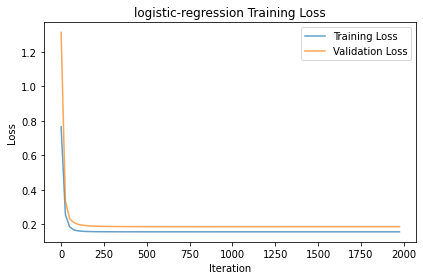

Linear(in_features=38, out_features=2, bias=True)

In [ ]:
%matplotlib inline

# Actually train a LogisticRegression; just one 'Linear' layer.
n_classes = len([0, 1])
model = nn.Linear(D, n_classes, bias=True)
objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1.0, momentum=0.9)

train("logistic-regression", model, optimizer, objective)

100%|██████████| 1000/1000 [00:01<00:00, 619.50it/s]


Validation. Acc: 0.935 Auc: 0.966


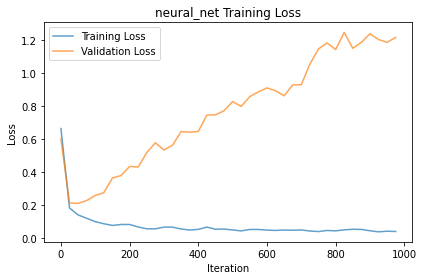

Sequential(
  (0): Linear(in_features=38, out_features=16, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
def make_neural_net(D: int, hidden: List[int], num_classes: int = 2, dropout=0.2):
    """ Using nn.Sequential; construct a list of layers that make this a neural-network. """
    layers = []
    for i, dim in enumerate(hidden):
        if i == 0:
            layers.append(nn.Linear(D, dim))
            layers.append(nn.Dropout(p=DROPOUT))
            layers.append(nn.ReLU())
        else:
            layers.append(nn.Linear(hidden[i - 1], dim))
            layers.append(nn.Dropout(p=DROPOUT))
            layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden[-1], num_classes))
    return nn.Sequential(*layers)

LEARNING_RATE = 1.0
DROPOUT = 0.2  # randomly turn off this fraction of the neural-net while training.
MOMENTUM = 0.9
REGULARIZATION = 0.   # try 0.1, 0.01, etc.

# two hidden layers, 16 nodes, each.
model = make_neural_net(D, [16, 16], dropout=DROPOUT)
objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=REGULARIZATION
)

train("neural_net", model, optimizer, objective, max_iter=1000)

## Lab TODO:
 1. Investigate LEARNING_RATE, DROPOUT, MOMENTUM, REGULARIZATION.
 2. What do you think these variables change?
 3. Consider a shallower, wider network. 
    - Changing [16,16] to something else... might require revisiting step 1.
